# Creating a temporal varying eddy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from wave_tracing_FE import Wave_tracing_FE
from scipy.stats import norm
import cmocean
import netCDF4# import Dataset

%matplotlib inline

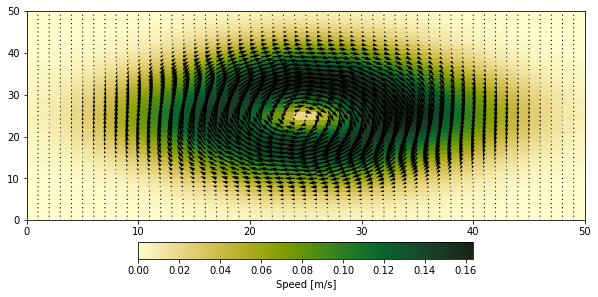

In [2]:
# A theoretical eddy
nx, ny = (50, 50)
x = np.linspace(-1, 0, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
u = np.pi*np.sin(np.pi*xv)*np.cos(np.pi*yv)
v = -np.pi*np.cos(np.pi*xv)*np.sin(np.pi*yv)

# weighten with a bell curve
x_weight = norm.pdf(np.arange(-3, 3, 6/nx),0,1)
y_weight = norm.pdf(np.arange(-3, 3, 6/ny),0,1)

#u/=np.pi
#v/=np.pi

for idx in range(u.shape[0]):
    u[idx,:] *= x_weight
    v[idx,:] *= x_weight

for idy in range(u.shape[1]):
    u[:,idy] *= y_weight
    v[:,idy] *= y_weight

#u*=x_weight
#v*=x_weight



fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
pc0 = ax.pcolormesh(np.sqrt(u**2 + v**2),cmap=cmocean.cm.speed)
ax.quiver(u,v)
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

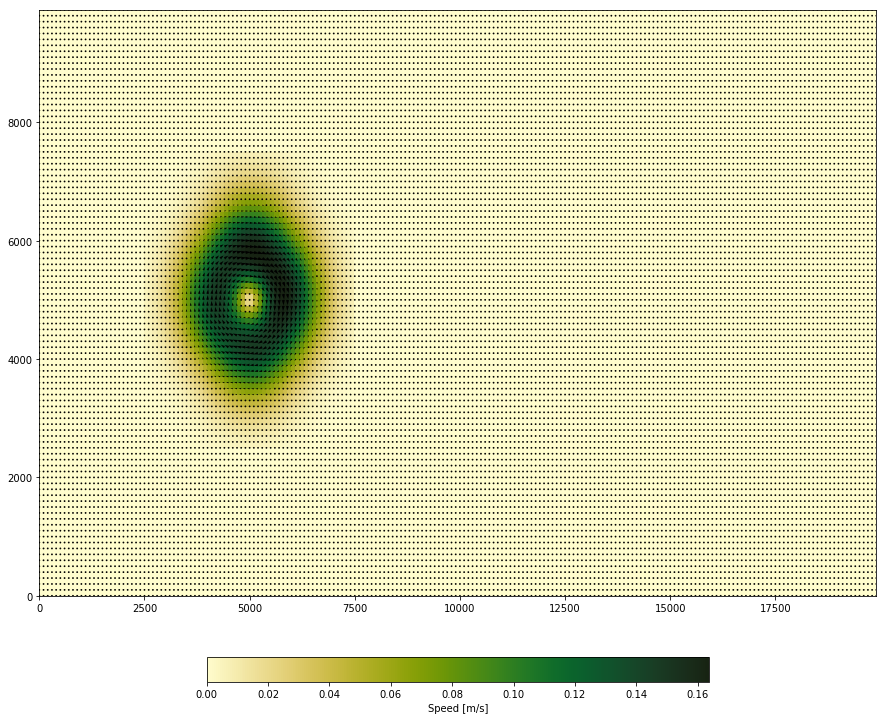

In [6]:
# Insert theoretical eddy in larger domain
dx=dy=100 #m

nny, nnx = (200,100)
xx = np.arange(nnx)*dx
yy = np.arange(nny)*dy
uu = np.zeros((nnx,nny))
vv = uu.copy()

uu[25:75,25:75] = u

vv[25:75,25:75] = v

speed = np.sqrt(uu**2 + vv**2)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(15,14))
pc0 = ax.pcolormesh(yy,xx,speed,cmap=cmocean.cm.speed)
ax.quiver(yy,xx,uu,vv,scale=25, scale_units='width')
fig.colorbar(pc0,ax=ax,orientation='horizontal',shrink=0.6,pad=0.08,label="Speed [m/s]")

In [7]:
nt = 24
U = np.zeros((nt,nnx,nny))
V = np.zeros((nt,nnx,nny))
SPEED = np.zeros((nt,nnx,nny))

temporal_weight=np.sin(np.linspace(0,np.pi,nt))

for idt,weight in enumerate(temporal_weight):
    U[idt,:,:] = weight*uu
    V[idt,:,:] = weight*vv
    SPEED[idt,:,:] = np.sqrt((weight*uu)**2 + (weight*vv)**2)

In [8]:
import datetime
T0 = np.datetime64('2000-01-01T00:00:00')
T = 3600 #[s]

#t_acq = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00', dtype='datetime64[h]')
#t_acq = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00', dtype='datetime64[h]')
t_acq = np.arange(T0, T0+np.timedelta64(T,'s'),np.timedelta64(int(((T/nt)*1e3)),'ms'))
t_acq = t_acq.astype('datetime64[s]')
td = t_acq-np.datetime64('1970-01-01T00:00:00','s') 

In [9]:
td

array([946684800, 946684950, 946685100, 946685250, 946685400, 946685550,
       946685700, 946685850, 946686000, 946686150, 946686300, 946686450,
       946686600, 946686750, 946686900, 946687050, 946687200, 946687350,
       946687500, 946687650, 946687800, 946687950, 946688100, 946688250],
      dtype='timedelta64[s]')

In [11]:
# Create nc file
out_netcdf = 'eddy.nc'

with (netCDF4.Dataset(out_netcdf, 'w', format='NETCDF4')) as ncout:
    dim_time = ncout.createDimension('time',nt)
    dim_x = ncout.createDimension('x',nnx)
    dim_y = ncout.createDimension('y',nny)
    nctime = ncout.createVariable('time','i4',('time',))

    # Set time value
    ##########################################################
    nctime.long_name = 'reference time for eddy'
    nctime.units = 'seconds since 1970-01-01 00:00:00'
    nctime.calendar = 'gregorian'
    nctime[:] = td
    
    # Add projection coordinates
    ##########################################################
    # Status
    
    ncx = ncout.createVariable('x','i4', 'x', zlib=True)
    ncx.units = 'm'
    ncx.standard_name= 'projection_x_coordinate'
    ncx[:] = xx
    ncy = ncout.createVariable('y','i4', 'y', zlib=True)
    ncy.units = 'm'
    ncy.standard_name= 'projection_y_coordinate'
    ncy[:] = yy
    
    # ADD U
    varout_u = ncout.createVariable('U',np.float32,
                    ('time', 'x', 'y'), zlib=True)
    varout_u.units = "meter second-1";                    
    varout_u.standard_name = 'x_sea_water_velocity'
    varout_u[:] = U#np.moveaxis(U, [2, 1], [1, 2])
    
    # ADD V
    varout_v = ncout.createVariable('V',np.float32,
                    ('time', 'x', 'y'), zlib=True)
    varout_v.units = "meter second-1";                    
    varout_v.standard_name = 'y_sea_water_velocity'
    varout_v[:] = V
    
    # ADD SPEED
    varout_sp = ncout.createVariable('speed',np.float32,
                    ('time', 'x', 'y'), zlib=True)
    varout_sp.units = "meter second-1";                    
    varout_sp.standard_name = 'speed'
    varout_sp[:] = SPEED
            

In [12]:
U.shape

(24, 100, 200)

In [13]:
yy

array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
        4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
       10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
       11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500,
       12600, 12700,